In [18]:
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "3"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
# from sklearn.model_selection import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from transformers import AutoTokenizer, AutoModel
from transformers import logging
logging.set_verbosity_error()


In [26]:
emails = [
    "Win a free iPhone now click here",
    "Limited time offer on credit cards",
    "Your account password needs reset",
    "Meeting tomorrow at 10am",
    "Huge discounts on electronics",
    "Please help me reset my account",
    "Your order has been shipped",
    "Family dinner this weekend",
    "Earn money working from home",
    "Support needed for login issue",
    "Happy birthday have a great year",
    "Buy one get one free sale",
    "System outage ticket raised",
    "Let's catch up over coffee",
    "Urgent verify your bank account"
]

labels = [
    "Spam", "Promotions", "Support", "Personal", "Promotions",
    "Support", "Support", "Personal", "Spam", "Support",
    "Personal", "Promotions", "Support", "Personal", "Spam"
]

df = pd.DataFrame({"email": emails, "category": labels})


In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    df["email"], df["category"], test_size=0.3, random_state=42
)

In [28]:
tfidf = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [29]:
baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train_tfidf, y_train)
baseline_preds = baseline_model.predict(X_test_tfidf)

In [30]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")

def embed_text(texts):
    inputs = tokenizer(list(texts), padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

X_train_emb = embed_text(X_train)
X_test_emb = embed_text(X_test)

Loading weights: 100%|█| 100/100 [00:00<00:00, 447.19it/s, Materializing param=transformer.layer.5.sa_layer_norm.weight


In [31]:
genai_model = LogisticRegression(max_iter=1000)
genai_model.fit(X_train_emb, y_train)
genai_preds = genai_model.predict(X_test_emb)


In [32]:
print("TF-IDF Model")
print(classification_report(y_test, baseline_preds))

print("GenAI Model")
print(classification_report(y_test, genai_preds))


TF-IDF Model
              precision    recall  f1-score   support

    Personal       0.25      1.00      0.40         1
  Promotions       0.00      0.00      0.00         1
        Spam       0.00      0.00      0.00         1
     Support       1.00      0.50      0.67         2

    accuracy                           0.40         5
   macro avg       0.31      0.38      0.27         5
weighted avg       0.45      0.40      0.35         5

GenAI Model
              precision    recall  f1-score   support

    Personal       1.00      1.00      1.00         1
  Promotions       1.00      1.00      1.00         1
        Spam       0.00      0.00      0.00         1
     Support       0.50      0.50      0.50         2

    accuracy                           0.60         5
   macro avg       0.62      0.62      0.62         5
weighted avg       0.60      0.60      0.60         5



C:\Users\S.SHRIHARI\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\S.SHRIHARI\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\S.SHRIHARI\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


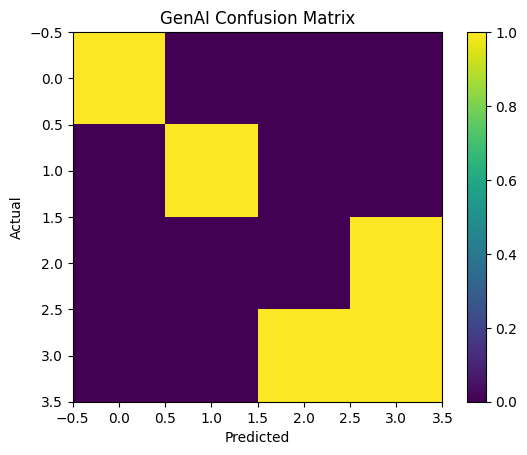

In [33]:
cm = confusion_matrix(y_test, genai_preds)
plt.imshow(cm)
plt.title("GenAI Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()

In [34]:
def classify_email(email_text):
    embedding = embed_text([email_text])
    return genai_model.predict(embedding)[0]

classify_email("Get flat 50 percent discount today")

'Promotions'

In [35]:
report = {
    "Baseline_F1": f1_score(y_test, baseline_preds, average="weighted"),
    "GenAI_F1": f1_score(y_test, genai_preds, average="weighted")
}

pd.DataFrame([report])

,Baseline_F1,GenAI_F1
0,0.346667,0.6
